## 準備

In [1]:
import warnings

import torch

device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)
dtype = torch.float16
variant = "fp16"
seed = 11

warnings.simplefilter("ignore", FutureWarning)

## Text-to-image
- 参考: https://hf.co/docs/diffusers/api/pipelines/stable_diffusion/stable_diffusion_2#text-to-image

### パイプラインの読み込み

In [2]:
from diffusers import (
    DPMSolverMultistepScheduler,
    StableDiffusionPipeline,
)

model_id = "stabilityai/stable-diffusion-2"

pipe = StableDiffusionPipeline.from_pretrained(
    model_id, torch_dtype=dtype, variant=variant
)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(
    pipe.scheduler.config
)
pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

### テキストから画像を生成する

  0%|          | 0/25 [00:00<?, ?it/s]

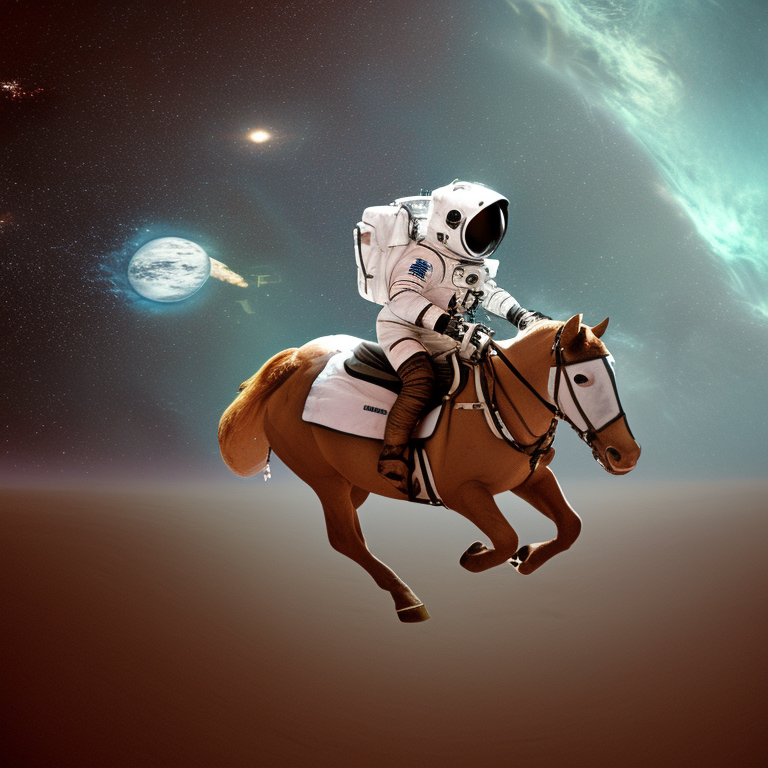

In [3]:
prompt = "High quality photo of an astronaut riding a horse in space"

output = pipe(
    prompt,
    num_inference_steps=25,
    generator=torch.manual_seed(seed),
)
image = output.images[0]

image

In [4]:
print(image.size)

(768, 768)


## Inpainting
- 参考: https://hf.co/docs/diffusers/api/pipelines/stable_diffusion/stable_diffusion_2#inpainting

### パイプラインの読み込み

In [5]:
from diffusers import StableDiffusionInpaintPipeline

model_id = "stabilityai/stable-diffusion-2-inpainting"

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    model_id, torch_dtype=dtype, variant=variant
)

pipe.scheduler = DPMSolverMultistepScheduler.from_config(
    pipe.scheduler.config
)
pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

### プロンプトを利用したマスク領域の再構成

  0%|          | 0/25 [00:00<?, ?it/s]

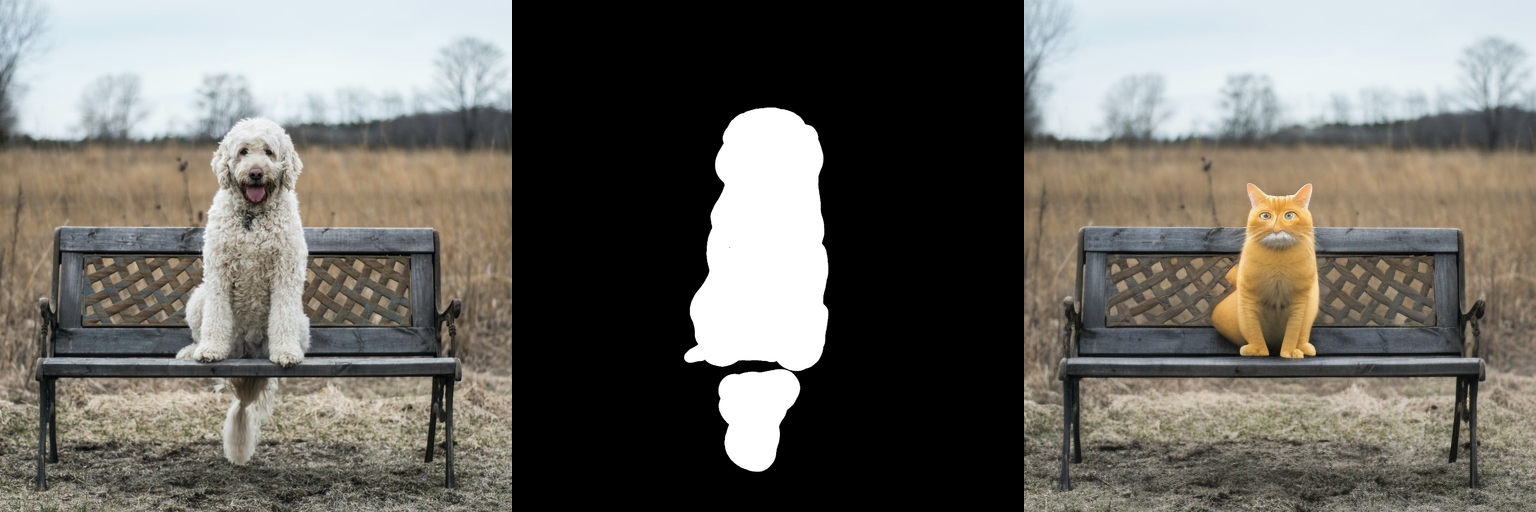

In [6]:
from diffusers.utils import load_image, make_image_grid

img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

init_image = load_image(img_url).resize((512, 512))
mask_image = load_image(mask_url).resize((512, 512))

prompt = "Face of a yellow cat, high resolution, sitting on a park bench"

image = pipe(
    prompt=prompt,
    image=init_image,
    mask_image=mask_image,
    num_inference_steps=25,
    generator=torch.manual_seed(seed),
).images[0]

make_image_grid(
    [init_image, mask_image, image], rows=1, cols=3
)

## Super-resolution

- 参考: https://hf.co/docs/diffusers/api/pipelines/stable_diffusion/stable_diffusion_2#super-resolution

### パイプラインの読み込み

In [7]:
from diffusers import StableDiffusionUpscalePipeline

model_id = "stabilityai/stable-diffusion-x4-upscaler"

pipe = StableDiffusionUpscalePipeline.from_pretrained(
    model_id, torch_dtype=dtype, variant=variant
)
pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

### 対象画像の超解像

  0%|          | 0/75 [00:00<?, ?it/s]

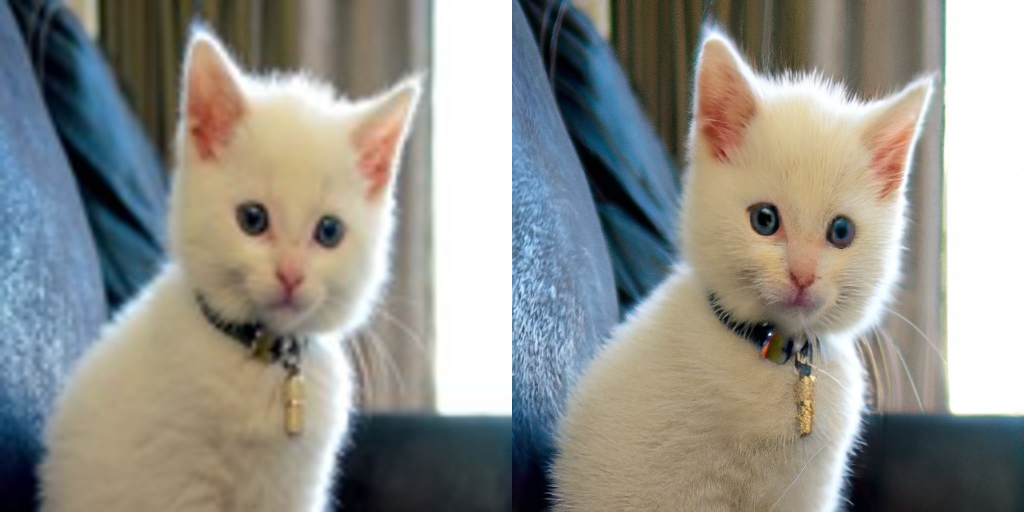

In [8]:
url = "https://hf.co/datasets/hf-internal-testing/diffusers-images/resolve/main/sd2-upscale/low_res_cat.png"
low_res_img = load_image(url)
low_res_img = low_res_img.resize((128, 128))

prompt = "a white cat"

upscaled_image = pipe(
    prompt=prompt,
    image=low_res_img,
    generator=torch.manual_seed(seed),
).images[0]

images = [
    low_res_img.resize((512, 512)),
    upscaled_image.resize((512, 512)),
]
make_image_grid(images, rows=1, cols=2)

## Depth-to-image
- 参考: https://hf.co/docs/diffusers/api/pipelines/stable_diffusion/stable_diffusion_2#depth-to-image

In [9]:
from diffusers import StableDiffusionDepth2ImgPipeline

model_id = "stabilityai/stable-diffusion-2-depth"

pipe = StableDiffusionDepth2ImgPipeline.from_pretrained(
    model_id, torch_dtype=dtype, variant=variant
)
pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

### 深度を考慮した画像を生成する

  0%|          | 0/35 [00:00<?, ?it/s]

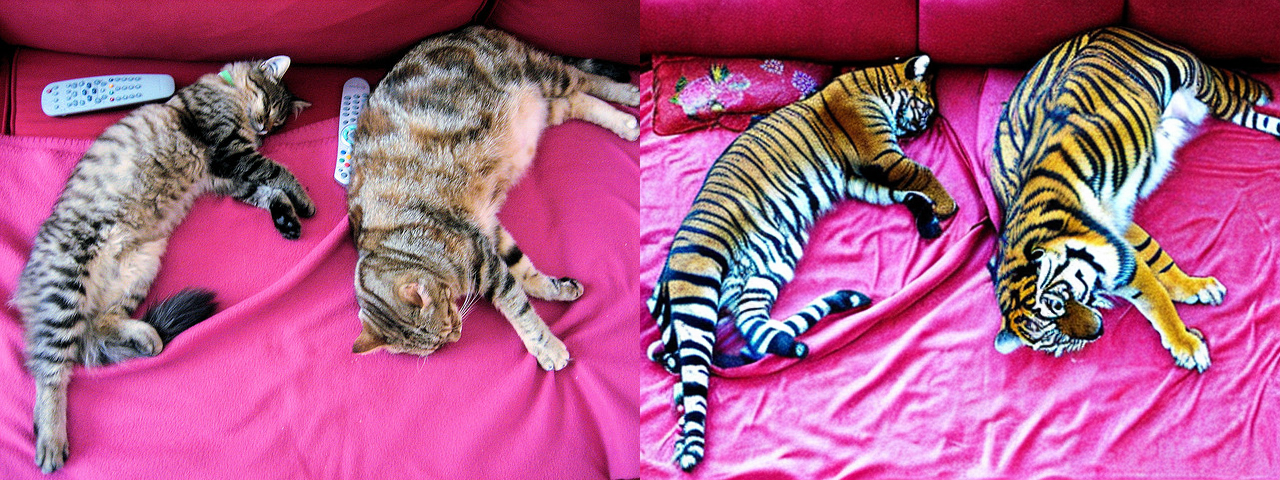

In [19]:
url = (
    "http://images.cocodataset.org/val2017/000000039769.jpg"
)
init_image = load_image(url)

prompt = "two tigers"
negative_prompt = "bad, deformed, ugly, bad anotomy"

image = pipe(
    prompt=prompt,
    image=init_image,
    negative_prompt=negative_prompt,
    strength=0.7,
).images[0]
make_image_grid([init_image, image], rows=1, cols=2)